<a href="https://colab.research.google.com/github/IgorEisenlohr/MVP-sprint-2/blob/main/MVP_sprint_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Aluno **Igor Miranda Eisenlohr**
* Problema escolhido foi referente a uma aplicação de **Visão computacional** com DeepLearning.
* O framework escolhido para desenvolver o projeto foi o **TensorFlow**.
* A base de dados contempla imagens de raio-x de pacientes que apresentavam **Pneumonia** e pacientes **normais** sem a doença
* Os dados foram retirados do **Kaggle** e armazenados no **github**.

# Trazendo os dados do github por meio de um clone do repositório

In [1]:
!git clone https://github.com/IgorEisenlohr/MVP-sprint-2.git

Cloning into 'MVP-sprint-2'...
remote: Enumerating objects: 5892, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 5892 (delta 14), reused 44 (delta 13), pack-reused 5843
Receiving objects: 100% (5892/5892), 1.22 GiB | 28.71 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (5860/5860), done.


# Importando as bibliotecas necessárias para o desenvolvimento

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import pickle

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import metrics
from keras.utils import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization

tf.random.set_seed(0)

# Separando os dados de treino, teste e validação

In [3]:
main_dir = '/content/MVP-sprint-2/chest_xray'

# train
train_dir = os.path.join(main_dir, 'train')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA')
train_normal = os.path.join(train_dir, 'NORMAL')

# val
val_dir = os.path.join(main_dir, 'val')
val_pneumonia = os.path.join(val_dir, 'PNEUMONIA')
val_normal = os.path.join(val_dir, 'NORMAL')

# test
test_dir = os.path.join(main_dir, 'test')
test_pneumonia = os.path.join(test_dir, 'PNEUMONIA')
test_normal = os.path.join(test_dir, 'NORMAL')

## Verificando a contagem de imagens em cada subset

### Treino

In [4]:
train_pneumonia_files = os.listdir(train_pneumonia)
print(f'Número de imagens de treino para pneumonia: {len(train_pneumonia_files)}')
train_normal_files = os.listdir(train_normal)
print(f'Número de imagens de treino para casos normais: {len(train_normal_files)}')

Número de imagens de treino para pneumonia: 3875
Número de imagens de treino para casos normais: 1341


percebe-se um desbalanceamento das classes de treino

### Validação

In [5]:
val_pneumonia_files = os.listdir(val_pneumonia)
print(f'Número de imagens de validação para pneumonia: {len(val_pneumonia_files)}')
val_normal_files = os.listdir(val_normal)
print(f'Número de imagens de validação para casos normais: {len(val_normal_files)}')

Número de imagens de validação para pneumonia: 8
Número de imagens de validação para casos normais: 8


percebe-se que a validação contempla pouquissimas imagens, talvez prefira utilizar parte da base de treino para a validação

### Teste

In [6]:
test_pneumonia_files = os.listdir(test_pneumonia)
print(f'Número de imagens de teste para pneumonia: {len(test_pneumonia_files)}')
test_normal_files = os.listdir(test_normal)
print(f'Número de imagens de teste para casos normais: {len(test_normal_files)}')

Número de imagens de teste para pneumonia: 390
Número de imagens de teste para casos normais: 234


Quantidade ok de imagens para testar a rede

## Visualizando algumas imagens de treino

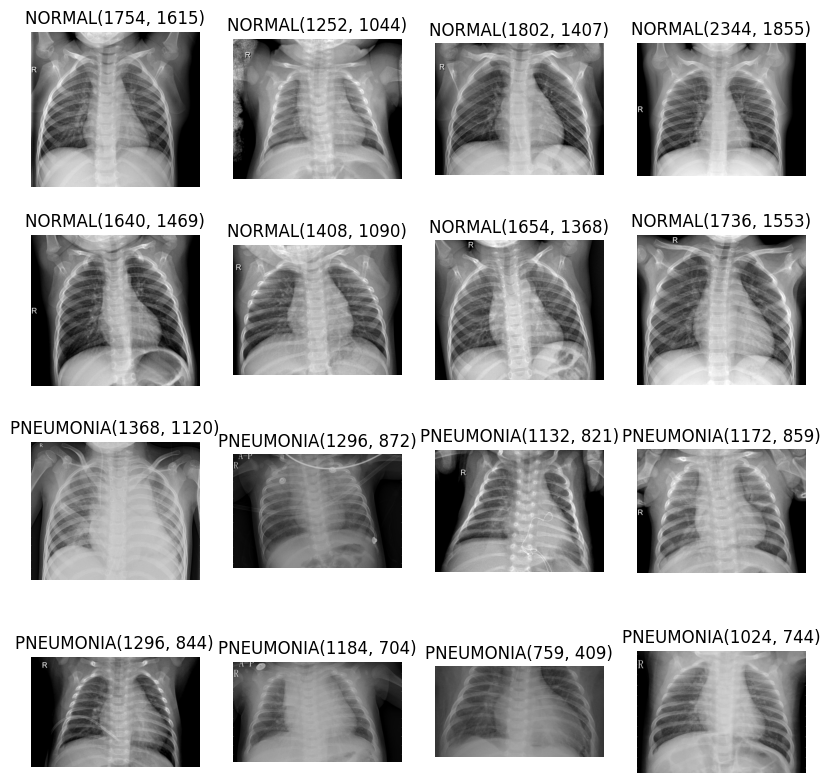

In [7]:
normal_images = [os.path.join(train_normal, filename) for filename in train_normal_files[0:8]]
pneumonia_images = [os.path.join(train_pneumonia, filename) for filename in train_pneumonia_files[0:8]]
images = normal_images+pneumonia_images

plt.figure(figsize=(10,10))
for i, image in enumerate(images, start=1):
  plt.subplot(4,4,i)
  img = Image.open(image)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(f"{image.split('/')[-2]}{img.size}")

# Preparando os dados que serão utilizados

In [8]:
shape = 150 # definindo tamanho que será utilizado

# Definindo etapa de Data Augmentation com algumas transformações
# Separando dados de treino em 2 subsets.

train_generator = ImageDataGenerator(rescale= 1./255, # Escala
                                     shear_range = 0.2, # Angulo
                                     zoom_range=0.1, # Zoom
                                     rotation_range=20, # Rotação
                                     brightness_range=[0.5,1.5], # Brilho
                                     horizontal_flip=True, # Inversão horizontal
                                     validation_split=0.2) # % de dados para validação


train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape), # Tamanho
                                                 batch_size=25, # Batch
                                                 class_mode='binary', # Pneumonia ou não (binário)
                                                 color_mode='grayscale', # Imagens em tons de cinza
                                                 subset='training') # Subset de treino

val_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape), # Tamanho
                                                 batch_size=25, # Batch
                                                 class_mode='binary', # Pneumonia ou não (binário)
                                                 color_mode='grayscale', # Imagens em tons de cinza
                                                 subset='validation') # Subset de validação

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


# Criação da rede

In [9]:
# Rede Neural

model = Sequential()

# Primeiras camadas para Visão computacional
# Camada 1
model.add(Conv2D(32, (3,3), activation='relu' ,input_shape=(shape,shape,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Camada 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Camada 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Vetor
model.add(Flatten())

# Camada para classificar os dados
model.add(Dense(128,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Em casos clinicos normalmente a acurácia não é a mais adequada. Com isso, vamos nos atentar a outras metricas também
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# Visualização de um batch pós transformações

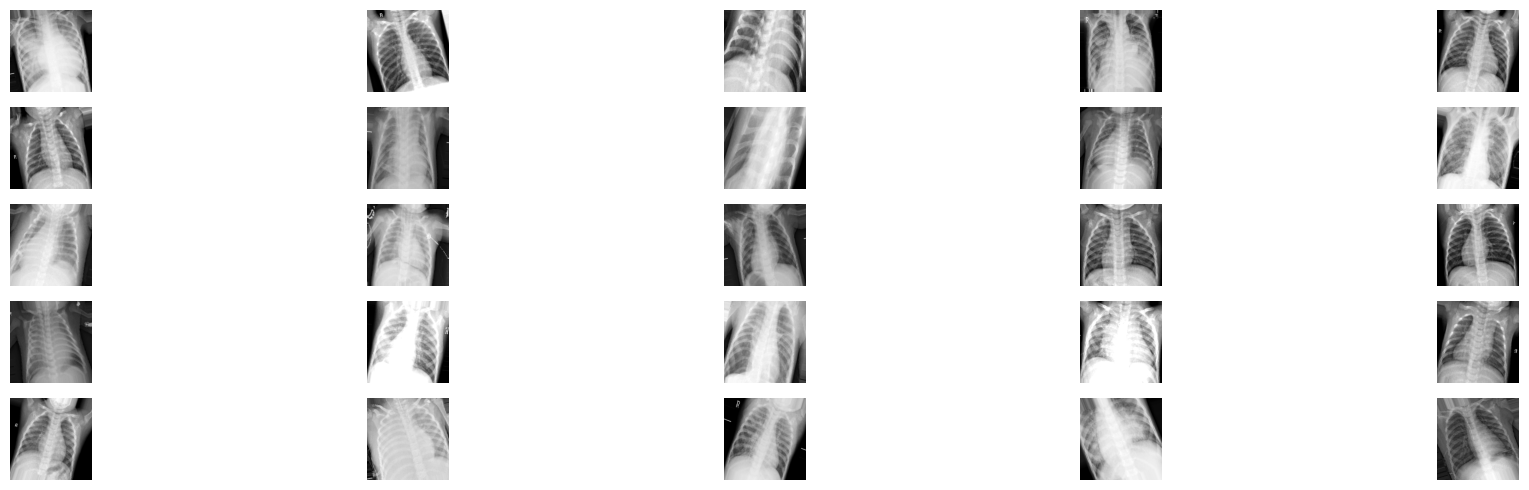

In [10]:
# Visualizando um batch de imagens após transformações

image_batch = train_data[0][0]

plt.figure(figsize=(20,5))
for i in range(len(image_batch)):
  plt.subplot(5,5,i+1)
  img = array_to_img(image_batch[i])
  plt.imshow(img, cmap='gray')
  plt.axis('off')
plt.tight_layout()

# Definindo callbacks

In [11]:
# Checkpoint do melhor modelo para os dados de validação
checkpoint = ModelCheckpoint('melhor_modelo.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Alterando o learning_rate caso não tenha melhora do modelo
lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.1)

# Parando a rede caso não tenha mais evolução
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [12]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=50,
                    validation_data=val_data,
                    callbacks=[checkpoint,lr,early_stopping],
                    validation_steps=len(val_data))

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.8258 - precision: 0.8761 - recall: 0.8916
Epoch 1: val_accuracy improved from -inf to 0.74305, saving model to melhor_modelo.h5
167/167 [==============================] - 76s 377ms/step - loss: 0.9978 - accuracy: 0.8258 - precision: 0.8761 - recall: 0.8916 - val_loss: 9.4989 - val_accuracy: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9085 - precision: 0.9334 - recall: 0.9442
Epoch 2: val_accuracy improved from 0.74305 to 0.75743, saving model to melhor_modelo.h5
167/167 [==============================] - 62s 371ms/step - loss: 0.2274 - accuracy: 0.9085 - precision: 0.9334 - recall: 0.9442 - val_loss: 1.3737 - val_accuracy: 0.7574 - val_precision: 0.7874 - val_recall: 0.9226 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9190 - pre

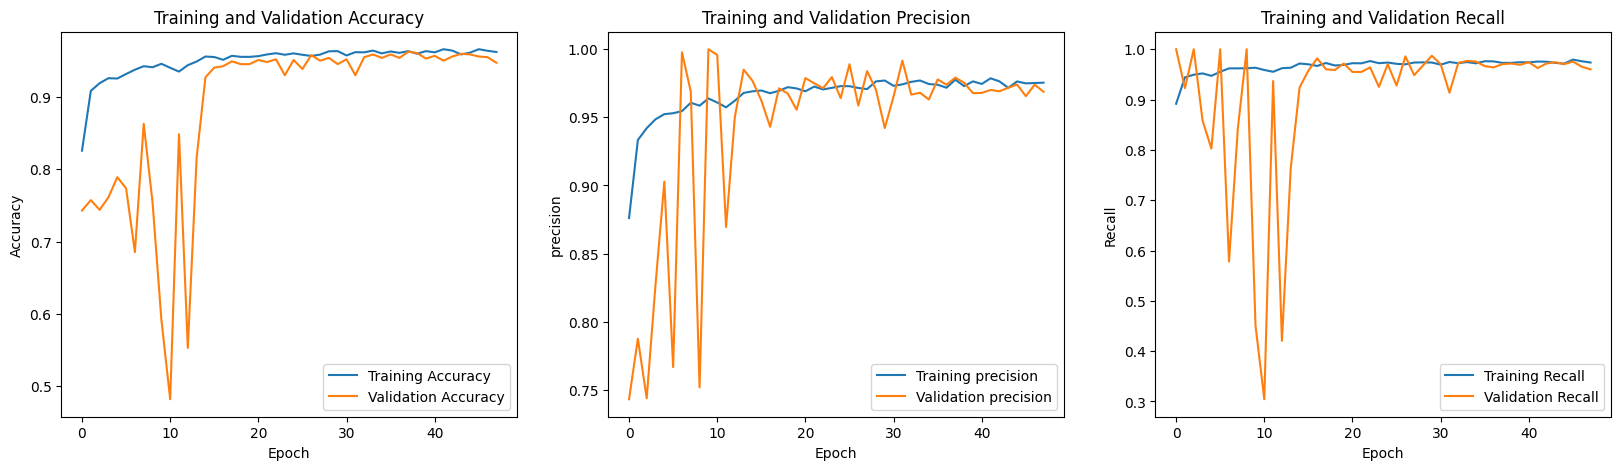

In [13]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(132)
plt.title('Training and Validation Precision')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(133)
plt.title('Training and Validation Recall')
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.show()

In [14]:
# Salvando o modelo
model.load_weights('melhor_modelo.h5')

Found 624 images belonging to 2 classes.
624/624 [==============================] - 6s 9ms/step
ROC AUC score: 85.04%
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       234
           1       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



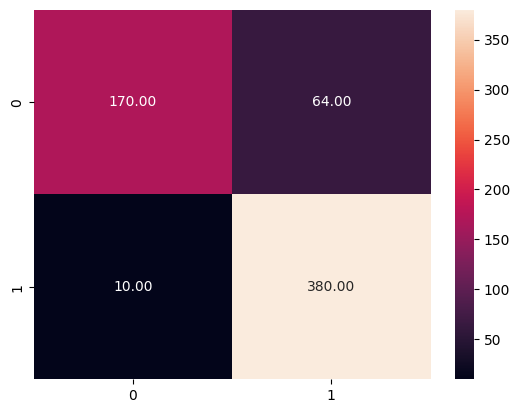

In [15]:
test_generator = ImageDataGenerator(rescale = 1./255)

test_data = test_generator.flow_from_directory(test_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               color_mode='grayscale',
                                               shuffle=False)

model.evaluate(test_data)
y_pred = model.predict(test_data)
y_pred[y_pred<=0.5] = 0
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%")
print(classification_report(test_data.classes, y_pred))

In [16]:
true_labels = test_generator.flow_from_directory(val_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               color_mode='grayscale',
                                               shuffle=False)

model.evaluate(true_labels)

pred_labels = model.predict(true_labels)
pred_labels[pred_labels<=0.5] = 0
pred_labels[pred_labels>0.5] = 1

Found 16 images belonging to 2 classes.
16/16 [==============================] - 0s 10ms/step


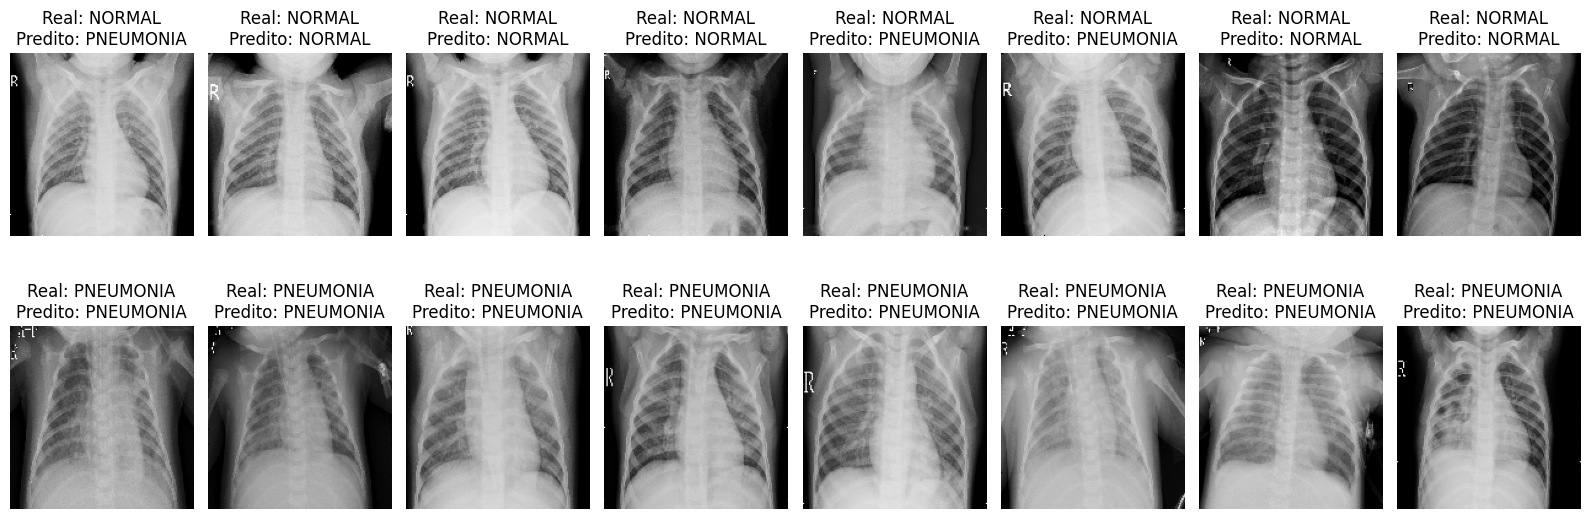

In [17]:
# Obter as previsões para as imagens de teste
predictions = pred_labels

# Obter as classes reais das imagens de teste
true_classes = true_labels.classes

# Obter os rótulos das classes (por exemplo, 'PNEUMONIA' e 'NORMAL')
class_labels = list(true_labels.class_indices.keys())

# Plotar as imagens com os rótulos
fig, axs = plt.subplots(2, 8, figsize=(16, 6))
axs = axs.ravel()

for i in range(len(true_classes)):
    # Carregar a imagem do diretorio val
    image = array_to_img(true_labels[i][0][0])

    # Obter o valor real da classe e o valor predito
    true_class = class_labels[true_classes[i]]
    predicted_class = class_labels[int(predictions[i] > 0.5)]

    # Plotar a imagem
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Real: {true_class}\nPredito: {predicted_class}')

plt.tight_layout()
plt.show()

## ResNet

In [18]:
train_generator = ImageDataGenerator(rescale= 1./255,
                                     shear_range = 0.2,
                                     zoom_range=0.2,
                                     rotation_range=20,
                                     brightness_range=[0.5,1.0],
                                     horizontal_flip=True,
                                     validation_split=0.2)


train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape),
                                                 batch_size=25,
                                                 class_mode='binary',
                                                 subset='training')

val_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=(shape,shape),
                                                 batch_size=25,
                                                 class_mode='binary',
                                                 subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [19]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(shape, shape, 3))
base_model.trainable = False

resnet = Sequential()
resnet.add(base_model)
resnet.add(Flatten())
resnet.add(Dense(1, activation='sigmoid'))
resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
resnet.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 23,616,001
Trainable params: 51,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:
checkpoint_resnet = ModelCheckpoint('melhor_resnet.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [21]:
resnet_history = resnet.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=50,
                            validation_data=val_data,
                            callbacks=[checkpoint_resnet,lr,early_stopping],
                            validation_steps=len(val_data))

Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.9113 - precision_1: 0.9400 - recall_1: 0.9406
Epoch 1: val_accuracy improved from -inf to 0.88495, saving model to melhor_resnet.h5
167/167 [==============================] - 87s 496ms/step - loss: 0.4977 - accuracy: 0.9113 - precision_1: 0.9400 - recall_1: 0.9406 - val_loss: 0.7606 - val_accuracy: 0.8849 - val_precision_1: 0.8684 - val_recall_1: 0.9961 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.9336 - precision_1: 0.9549 - recall_1: 0.9558
Epoch 2: val_accuracy improved from 0.88495 to 0.93576, saving model to melhor_resnet.h5
167/167 [==============================] - 81s 483ms/step - loss: 0.4712 - accuracy: 0.9336 - precision_1: 0.9549 - recall_1: 0.9558 - val_loss: 0.5710 - val_accuracy: 0.9358 - val_precision_1: 0.9903 - val_recall_1: 0.9226 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 0.4557 

In [22]:
resnet.load_weights('melhor_resnet.h5')

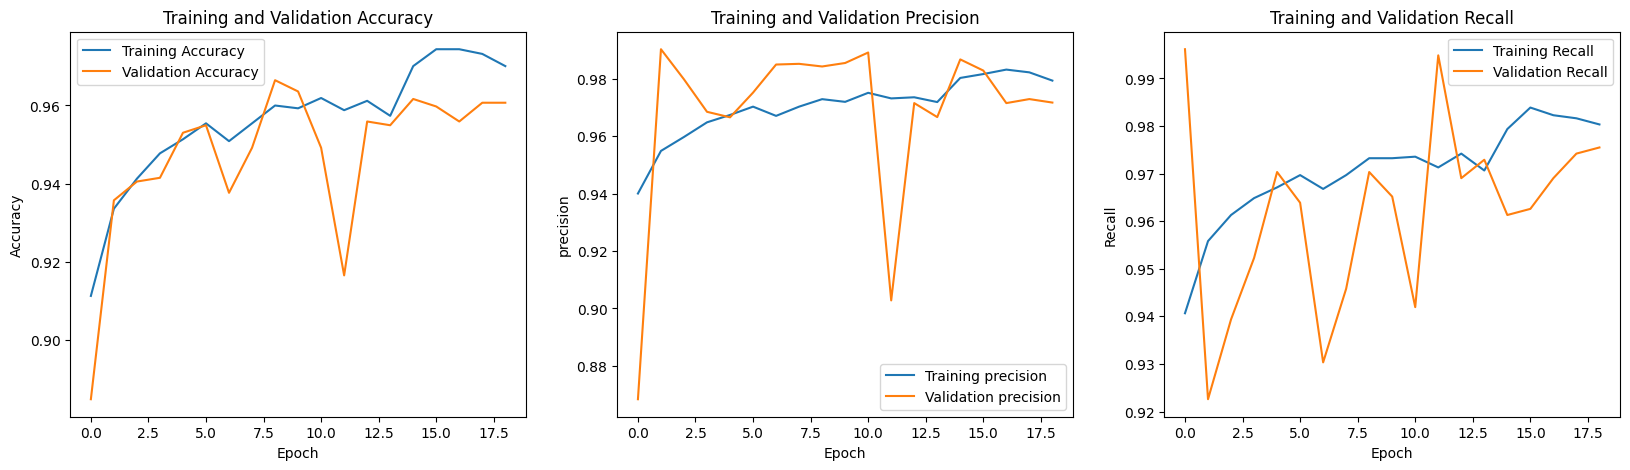

In [25]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('Training and Validation Accuracy')
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(132)
plt.title('Training and Validation Precision')
plt.plot(resnet_history.history['precision_1'], label='Training precision')
plt.plot(resnet_history.history['val_precision_1'], label='Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(133)
plt.title('Training and Validation Recall')
plt.plot(resnet_history.history['recall_1'], label='Training Recall')
plt.plot(resnet_history.history['val_recall_1'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.show()

Found 624 images belonging to 2 classes.
624/624 [==============================] - 7s 11ms/step
ROC AUC score: 90.3%
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       234
           1       0.91      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



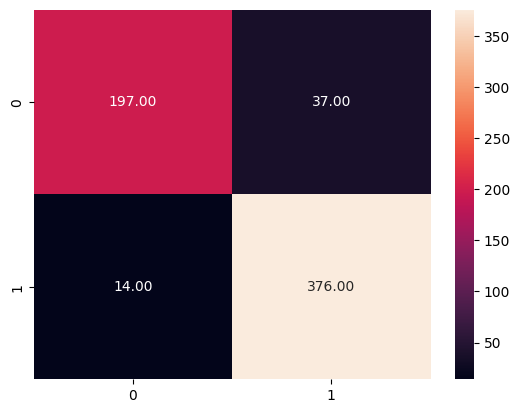

In [26]:
test_data = test_generator.flow_from_directory(test_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               shuffle=False)

resnet.evaluate(test_data)
y_pred = resnet.predict(test_data)
y_pred[y_pred<=0.5] = 0
y_pred[y_pred>0.5] = 1
cm = confusion_matrix(test_data.classes, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='.2f')

print(f"ROC AUC score: {round(roc_auc_score(test_data.classes, y_pred),4)*100}%")
print(classification_report(test_data.classes, y_pred))

In [27]:
true_labels = test_generator.flow_from_directory(val_dir,
                                               target_size=(shape,shape),
                                               batch_size=1,
                                               class_mode='binary',
                                               shuffle=False)

resnet.evaluate(true_labels)

pred_labels = resnet.predict(true_labels)
pred_labels[pred_labels<=0.5] = 0
pred_labels[pred_labels>0.5] = 1

Found 16 images belonging to 2 classes.
16/16 [==============================] - 0s 12ms/step


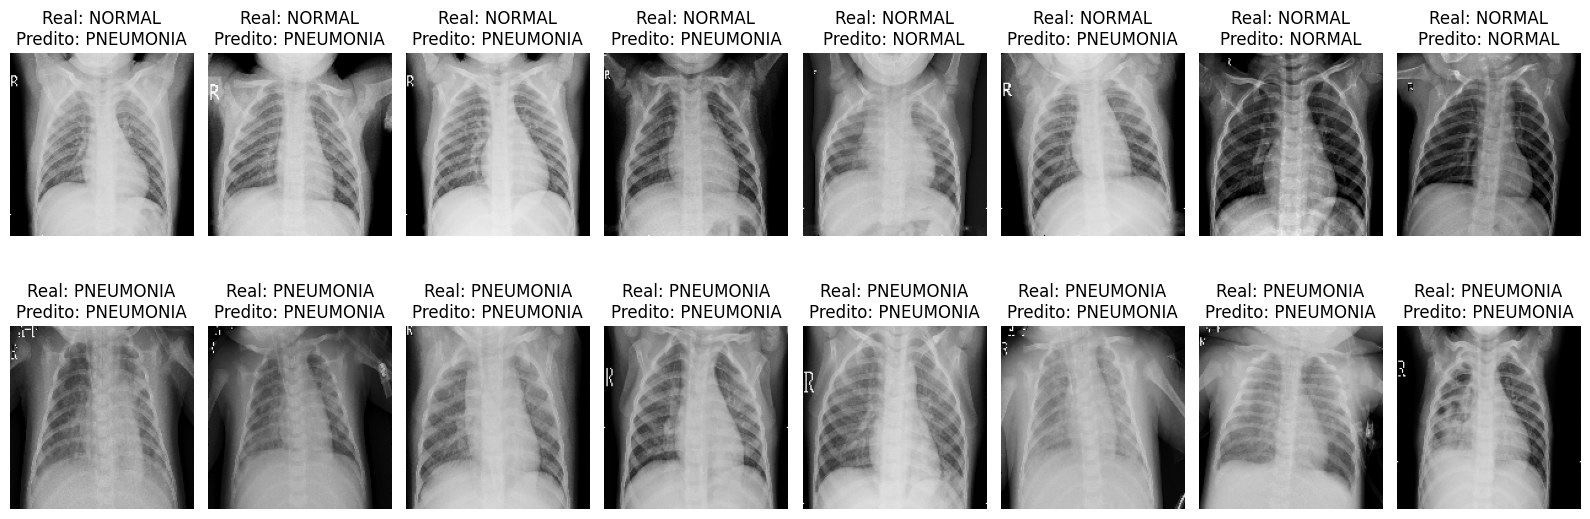

In [28]:
# Obter as previsões para as imagens de teste
predictions = pred_labels

# Obter as classes reais das imagens de teste
true_classes = true_labels.classes

# Obter os rótulos das classes (por exemplo, 'PNEUMONIA' e 'NORMAL')
class_labels = list(true_labels.class_indices.keys())

# Plotar as imagens com os rótulos
fig, axs = plt.subplots(2, 8, figsize=(16, 6))
axs = axs.ravel()

for i in range(len(true_classes)):
    # Carregar a imagem do diretorio val
    image = array_to_img(true_labels[i][0][0])

    # Obter o valor real da classe e o valor predito
    true_class = class_labels[true_classes[i]]
    predicted_class = class_labels[int(predictions[i] > 0.5)]

    # Plotar a imagem
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Real: {true_class}\nPredito: {predicted_class}')

plt.tight_layout()
plt.show()